In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

import pyvene as pv
import torch
import transformers
from dataclasses import dataclass
from typing import List, Optional
import jax
import hydra
import lightning as L
import torch
from hydra.core.config_store import ConfigStore
from lightning.pytorch.loggers import WandbLogger
from omegaconf import MISSING, DictConfig, OmegaConf, open_dict
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
from task import MetaLearningTask, TaskConfig
import warnings
import numpy as np
from torch.utils.data import DataLoader, Subset
import lightning as L
from typing import *
from dataclasses import dataclass
import torch
from transformers import GPT2LMHeadModel, GPT2Config
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
from models.gpt import GPT, GPTConfig
from task import MetaLearningTask
from train import TrainConfig
from itertools import product, combinations
from omegaconf.dictconfig import DictConfig
from transformers import PreTrainedModel, PretrainedConfig
import torch.nn as nn
from datasets import load_dataset, Dataset, IterableDataset
import evaluate
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
import hmmlearn
from sklearn.preprocessing import normalize
from copy import deepcopy
from pympler import asizeof
from hmmlearn.base import _hmmc
import gc
from functools import partial
from torchmetrics.functional import kl_divergence

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap
from jax.nn import one_hot

from dynamax.hidden_markov_model import CategoricalHMM
from dynamax.hidden_markov_model.models.categorical_hmm import (
    ParamsCategoricalHMM,
    ParamsStandardHMMTransitions,
    ParamsCategoricalHMMEmissions,
    ParamsStandardHMMInitialState,
)
from jax.scipy.special import logsumexp, rel_entr
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from models.mamba import MambaConfig, MambaLMHeadModel
from torch2jax import j2t, t2j


/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_nor

In [5]:
model = MambaLMHeadModel(
    MambaConfig(
        d_model=512,
        n_layer=6,
        vocab_size=60,
        ssm_cfg={"layer": "Mamba2", "d_state": 8, "d_conv": 4},
    )
)

In [2]:
task = MetaLearningTask('e0s5davz')
task : MetaLearningTask
task.eval()

Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=216,step=9750.ckpt


MetaLearningTask(
  (model): MambaLMHeadModel(
    (backbone): MixerModel(
      (embedding): Embedding(56, 256)
      (layers): ModuleList(
        (0-3): 4 x Block(
          (norm): RMSNorm()
          (mixer): Mamba2(
            (in_proj): Linear(in_features=256, out_features=1048, bias=False)
            (conv1d): Conv1d(528, 528, kernel_size=(4,), stride=(1,), padding=(3,), groups=528)
            (act): SiLU()
            (norm): RMSNorm()
            (out_proj): Linear(in_features=512, out_features=256, bias=False)
          )
        )
      )
      (norm_f): RMSNorm()
    )
    (lm_head): Linear(in_features=256, out_features=56, bias=False)
  )
)

In [5]:
predicted_envs = np.unique(task.val_data.indices)

envs = jr.choice(jr.PRNGKey(0), predicted_envs, (10,))
Xs = jax.vmap(task.full_data.sample, (0, None, 0))(
    envs, 250, jr.split(jr.PRNGKey(0), len(envs))
)
# Gather the model's posterior predictive
with torch.no_grad():
    task.model.cuda()
    model_pp = torch.softmax(
        task.model.forward(
            j2t(Xs),
            only_last_logits=False,
        ),
        dim=-1,
    )
    model_pp = t2j(model_pp)
    task.model.cpu()

In [7]:
assumed_envs = jnp.arange(len(task.full_data))

In [8]:
jax.vmap(task.full_data.filter, (0, None))(assumed_envs, Xs[0,1:])

NameError: name 'Xs' is not defined

In [9]:
assumed_envs = jnp.arange(len(task.full_data))


In [12]:
asdf = task.full_data.posterior_predictive(assumed_envs, Xs[0,1:])

In [25]:
task.full_data.index_to_latent.device

CpuDevice(id=0)

In [18]:
task.model.lm_head._parameters['weight'].device

device(type='cpu')

In [9]:
xd = task.evaluate_pp(128, 250)

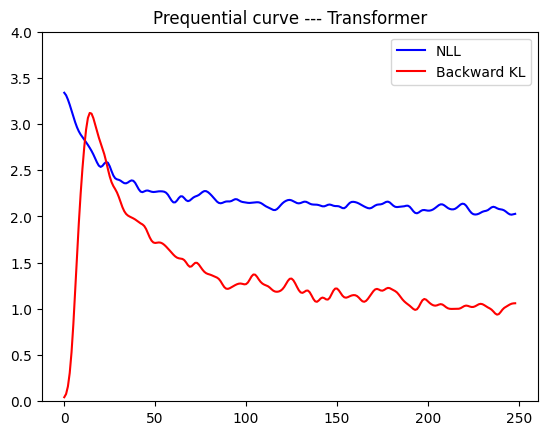

In [10]:
#plt.plot(gaussian_filter1d(xd['ForwardKL'].cpu().mean(0),2), label='Forward (long)', color='red')
plt.plot(gaussian_filter1d(xd['ModelNLL'].cpu().mean(0),2), label='NLL', color='blue')
plt.plot(gaussian_filter1d(xd['BackwardKL'].cpu().mean(0),2), label='Backward KL', color='red')
plt.title('Prequential curve --- Transformer')
plt.ylim(0,4)
plt.legend()